In [1]:
!rm -r *
!wget -q https://nayeemmz.github.io/cmsc426Spring2021/assets/hw2/hw2.zip
!unzip -q hw2.zip
!mv hw2/* ..
!rm -r __MACOSX/ hw2/ hw2.zip

rm: cannot remove '*': No such file or directory
mv: cannot move 'hw2/code' to '../code': Directory not empty
mv: cannot move 'hw2/images' to '../images': Directory not empty


In [2]:
!mv ../images/set1/* ../images/input

mv: cannot stat '../images/set1/*': No such file or directory


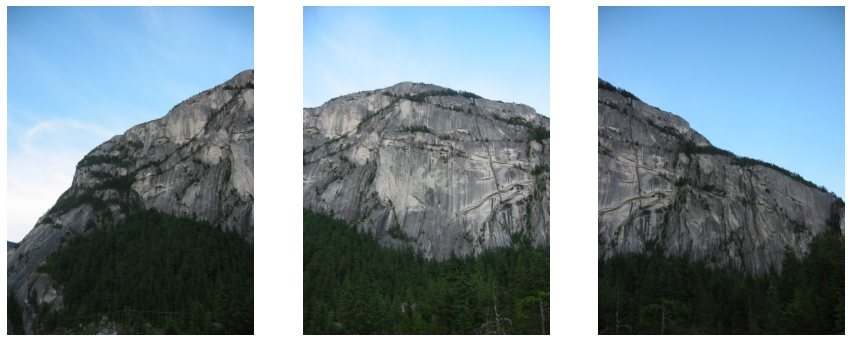

In [3]:
import cv2
import matplotlib.pyplot as plt
import glob

directory = '../images/set2'
image_color = []
image_gray = []
for filename in glob.glob(f'{directory}/*.jpg'):
    im=cv2.imread(filename)
    image_color.append(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    image_gray.append(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY))

figsize = (15,10)
fig = plt.figure(figsize=figsize)
for i in range(len(image_color)):
    fig.add_subplot(1, len(image_color), i+1)
    plt.imshow(image_color[i]), plt.axis('off')
plt.show()

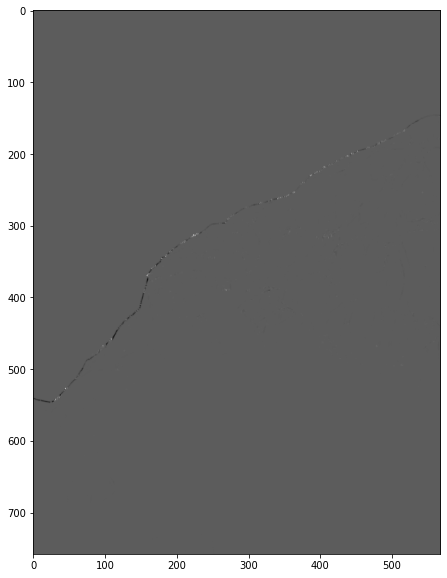

In [4]:
import cv2
import numpy as np

corner_scores = np.array([cv2.cornerHarris(np.float32(im), 2, 3, 0.04) for im in image_gray])

plt.figure(figsize=figsize)
plt.imshow(corner_scores[0]), plt.gray()
plt.show()

In [ ]:
def imregionalmax(image, kernel=None):
    local_max = cv2.dilate(image, kernel)
    max_mask = image >= local_max
    local_min = cv2.erode(image, kernel)
    min_mask = image > local_min
    return (max_mask & min_mask).astype(np.uint8)

def anms(C, N_best=200, c_robust=0.9):
    strong = np.nonzero(imregionalmax(C))
    strong_t = np.transpose(strong)
    N_strong = len(strong[0])
    vals = C[strong]

    r = np.full(N_strong, np.inf)
    for i in range(N_strong):
        robust = strong_t[vals[i] < vals * c_robust]
        if robust.size == 0: continue
        r[i] = np.min(((robust - strong_t[i]) ** 2).sum(-1))

    best = strong_t[np.argsort(r)[-N_best:]]
    return best

ips = np.array([anms(C) for C in corner_scores])

fig = plt.figure(figsize=figsize)
plt.imshow(image_color[0])
for point in ips[0]:
    plt.gca().add_patch(plt.Circle(point[::-1], radius=1, color='r'))
plt.axis('off')
plt.show()

In [ ]:
def get_feature_vector(ip, im, s=5, ps=40):
    pw = ps/2
    patch = im[int(ip[0] - pw) : int(ip[0] + pw),
               int(ip[1] - pw) : int(ip[1] + pw)]
    
    patch_blur = cv2.GaussianBlur(patch, (3, 3), 0)
    subsample = patch_blur[::s, ::s]
    #subsample = cv2.GaussianBlur(patch, (3, 3), 0)[::s, ::s]
    vec = subsample.flatten()
    vec = (vec - vec.mean()) / vec.std()

    return vec

def compute_descriptors(ips, im, s=5, ps=40):
    pw = int(ps/2)
    pad_image = np.pad(im, pw)
    pad_points = ips + [pw, pw]

    vecs = np.array([get_feature_vector(ip, pad_image, s, ps)
                     for ip in pad_points])
    
    return vecs

desc = np.array([compute_descriptors(ips, im)
                 for ips, im in zip(ips, image_gray)])

plt.imshow(desc[0][8].reshape(8,8)), plt.gray()
plt.show()

In [ ]:
def find_correspondence(desc, desc_list, t=0.5):
    dist = np.abs(desc_list - desc).sum(-1)
    smallest = np.argsort(dist)[:2]
    ratio = dist[smallest[0]] / dist[smallest[1]]
    return smallest[0] if ratio < t else None

def find_correspondences(desc1, desc2):
    correspondences = []
    for i, desc in enumerate(desc1):
        correspondence = find_correspondence(desc, desc2)
        if correspondence is not None:
            correspondences.append([i, correspondence])
    return np.array(correspondences)

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

c = find_correspondences(desc[0], desc[1])
plt.figure(figsize=figsize)
plt.imshow(drawMatches(image_color[0], ips[0], image_color[1], ips[1], c))
plt.axis('off')
plt.show()

In [ ]:
def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

def try_homography(ips1, ips2, c, t=4):
    pairs = c[np.random.choice(len(c), 4, replace=False)]
    H = est_homography(ips1[pairs[:,0]], ips2[pairs[:,1]])
    Hpi = apply_homography(H, ips1[c[:,0]])
    inliers = c[np.abs(Hpi - ips2[c[:,1]]).sum(-1) < t]
    return inliers

def ransac(ips1, ips2, c, n_iter=300, p=0.8):
    ips1_c, ips2_c = ips1[:,::-1], ips2[:,::-1]
    t = p * len(c)

    inliers = np.array([])
    for i in range(n_iter):
        h_in = try_homography(ips1_c, ips2_c, c)
        if len(h_in) > len(inliers):
            inliers = h_in
        if len(inliers) >= t: break
    
    H = est_homography(ips1_c[inliers[:,0]], ips2_c[inliers[:,1]])
    return H, inliers

H, inliers = ransac(ips[0], ips[1], c)
plt.figure(figsize=figsize)
plt.imshow(drawMatches(image_color[0], ips[0],
                       image_color[1], ips[1],
                       inliers))
plt.axis('off')
plt.show()

In [ ]:
def get_corners(im):
    return np.array([[0, 0],
                     [0, im.shape[0]],
                     [im.shape[1], 0],
                     [im.shape[1], im.shape[0]]])

def blend(im1, im2, H):
    corners1 = apply_homography(H, get_corners(im1))
    corners2 = get_corners(im2)
    corners = np.concatenate((corners1, corners2)).T

    minx, miny = np.min(corners[0]), np.min(corners[1])
    canvasx = int(np.max(corners[0]) - minx)
    canvasy = int(np.max(corners[1]) - miny)

    trans_m = np.array([[1, 0, -minx],
                        [0, 1, -miny],
                        [0, 0, 1]])
    Ht = trans_m @ H
    
    im1_warp = cv2.warpPerspective(im1, Ht, (canvasx, canvasy))
    im2_warp = cv2.warpPerspective(im2, np.float32(trans_m), (canvasx, canvasy))
    output = np.maximum(im1_warp, im2_warp)
    output_gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)

    return output, output_gray, Ht, trans_m

output, output_gray, Ht, trans_m = blend(image_color[0], image_color[1], H)

plt.figure(figsize=figsize)
plt.imshow(output), plt.axis('off')
plt.show()

In [ ]:
def compute_new_ips(ips1, ips2, Ht, trans_m):
    ips1_c, ips2_c = ips1[:,::-1], ips2[:,::-1]
    new_ips1 = apply_homography(Ht, ips1_c)[:,::-1]
    new_ips2 = apply_homography(trans_m, ips2_c)[:,::-1]
    new_ips = np.concatenate((new_ips1, new_ips2))
    return new_ips

new_ips = compute_new_ips(ips[0], ips[1], Ht, trans_m)
plt.imshow(output)
plt.scatter(*new_ips.T[::-1])
plt.show()

new_desc = compute_descriptors(new_ips, output_gray)

In [ ]:
for im_i, ips_i, desc_i in zip(image_color[2:], ips[2:], desc[2:]):    
    c = find_correspondences(desc_i, new_desc)
    H, inliers = ransac(ips_i, new_ips, c)
    output, output_gray, Ht, trans_m = blend(im_i, output, H)
    new_ips = compute_new_ips(ips_i, new_ips, Ht, trans_m)
    new_desc = compute_descriptors(new_ips, output_gray)
    
fig = plt.figure(figsize=figsize)
plt.imshow(output), plt.axis('off')
plt.show()